<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/pressure_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pressure control implementations in water distribution networks
### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London\
Autumn 2023

### Preamble
This notebook walks through the following pressure control implementations in water distribution network operations:
- Fixed outlet
- Time-based
- Flow modulation
- Model-based optimization

Code implementations for flow modulation and model-based optimal control will be presented.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [27]:
# Run this cell once in Google Colab
!git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
!pip install wntr

Cloning into 'CIVE_70019_70057'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 207 (delta 5), reused 13 (delta 4), pack-reused 190
Receiving objects: 100% (207/207), 2.31 MiB | 10.53 MiB/s, done.
Resolving deltas: 100% (93/93), done.


### Data preparation

Load data provided in the module repository.

In [45]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

data_dir = '/content/CIVE_70019_70057/data/operational_data/data.npy'

# Load elevation and operational data
data = np.load(data_dir, allow_pickle=True).item()

# Assign variables
inlet_pressure = data['p_in']
outlet_pressure = data['p_out']
critical_pressure = data['p_critical']
flow = data['flow']
outlet_elev = data['outlet_elev']
critical_elev = data['critical_elev']

from datetime import datetime, timedelta

# Define datetime list (do not change)
start_date = datetime(2021, 1, 1, 0, 0)
num_values = 576
time_interval = timedelta(minutes=15)
datetime = [start_date + i * time_interval for i in range(num_values)]

Visualise operational data.

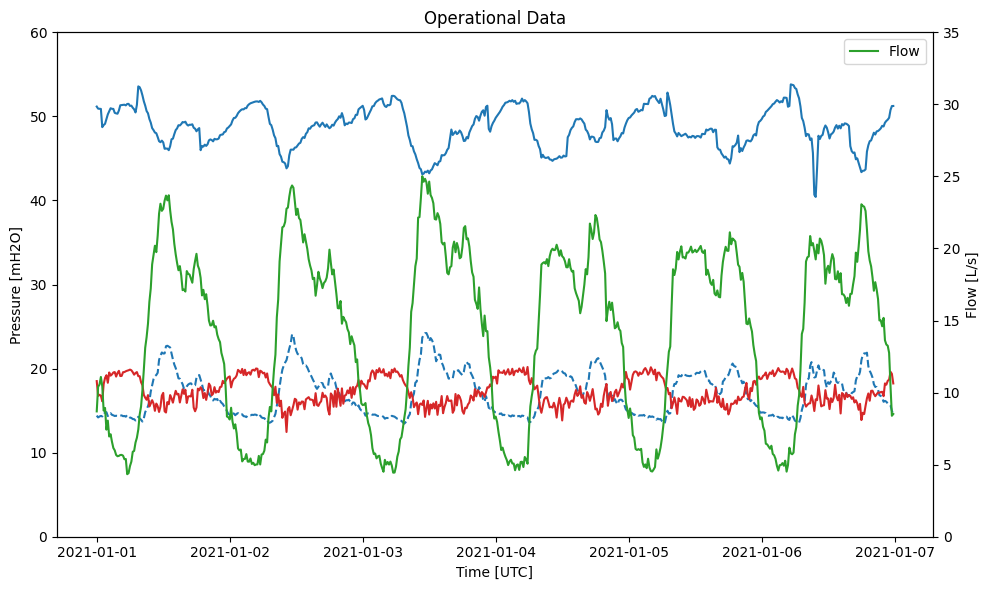

In [78]:
# Create a figure and plot the data
plt.figure(figsize=(10, 6))

# Plot pressure on the primary y-axis
plt.plot(datetime, inlet_pressure, '-', label='Inlet Pressure', color='tab:blue')
plt.plot(datetime, outlet_pressure, '--', label='Outlet Pressure', color='tab:blue')
plt.plot(datetime, critical_pressure, '-', label='Critical Pressure', color='tab:red')

plt.ylim([0, 60])
plt.title('Operational Data')
plt.ylabel('Pressure [mH2O]')
plt.xlabel('Time [UTC]')

# Plot flow on the secondary y-axis
plt.twinx()
plt.plot(datetime, flow, '-', label='Flow', color='tab:green')
plt.ylim([0, 35])
plt.ylabel('Flow [L/s]')

# Place the legend in the upper right corner
plt.legend()

plt.tight_layout()
plt.show()